In [10]:
import tensorflow as tf
import numpy as np
from keras import datasets, layers, models
import matplotlib.pyplot as plt

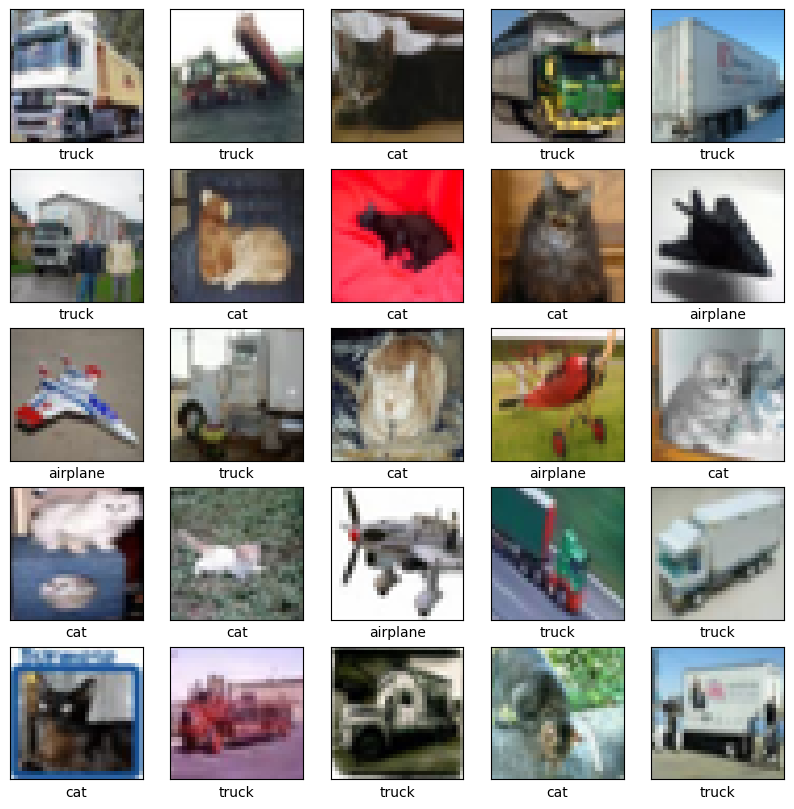

In [11]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Define the selected classes
selected_classes = ['airplane', 'cat', 'truck']

# Find indices of selected classes in CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
selected_indices = [class_names.index(class_name) for class_name in selected_classes]

# Filter the dataset to include only the selected classes
train_mask = [label[0] in selected_indices for label in train_labels]
test_mask = [label[0] in selected_indices for label in test_labels]

train_images = train_images[train_mask]
train_labels = train_labels[train_mask]

test_images = test_images[test_mask]
test_labels = test_labels[test_mask]

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Display sample images
plt.figure(figsize=(10, 10))
image_count = 1

for i in range(len(train_labels)):
    plt.subplot(5, 5, image_count)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    
    # Map CIFAR-10 label to the selected class index
    label_index = selected_indices.index(train_labels[i][0])
    plt.xlabel(selected_classes[label_index])
    
    image_count += 1

    if image_count > 25:  # Display only 25 images
        break

plt.show()


### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of your model so far:

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56320 (220.00 KB)
Trainable params: 56320 

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [14]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Load the pre-trained model or train it
try:
    model = tf.keras.models.load_model('odel/cnn.h5')
except:
    history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
    test_f1 = 2 * (test_acc * test_acc) / (test_acc + test_acc)
    print(f'Test accuracy: {test_acc}')
    print(f'Test f1 macro: {test_f1}')

    # Save the trained model
    model.save('model/cifar_cnn.h5')

Epoch 1/10
469/469 [==============================] - 8s 16ms/step - loss: 0.6479 - accuracy: 0.7291 - val_loss: 0.4574 - val_accuracy: 0.8227
Epoch 2/10
469/469 [==============================] - 8s 16ms/step - loss: 0.4383 - accuracy: 0.8296 - val_loss: 0.4184 - val_accuracy: 0.8397
Epoch 3/10
469/469 [==============================] - 7s 16ms/step - loss: 0.3777 - accuracy: 0.8551 - val_loss: 0.3575 - val_accuracy: 0.8670
Epoch 4/10
469/469 [==============================] - 7s 15ms/step - loss: 0.3226 - accuracy: 0.8763 - val_loss: 0.3122 - val_accuracy: 0.8860
Epoch 5/10
469/469 [==============================] - 7s 16ms/step - loss: 0.2914 - accuracy: 0.8901 - val_loss: 0.3352 - val_accuracy: 0.8717
Epoch 6/10
469/469 [==============================] - 7s 16ms/step - loss: 0.2584 - accuracy: 0.9037 - val_loss: 0.3469 - val_accuracy: 0.8763
Epoch 7/10
469/469 [==============================] - 7s 16ms/step - loss: 0.2279 - accuracy: 0.9165 - val_loss: 0.2935 - val_accuracy: 0.8990

c:\Users\91843\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
for layer in model.layers:
    print(layer.name)


conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
flatten
dense
dense_1


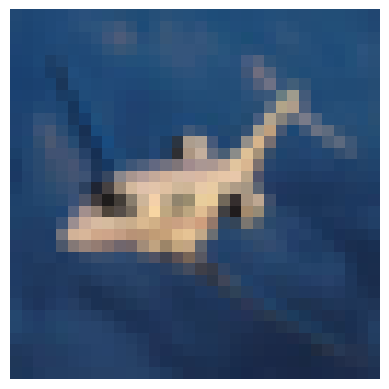

Probability that the given image is 8 : 7.562671184539795


In [18]:
#positive class at 61
image = test_images[61]

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Make the model predict on the image
prediction = model.predict(image.reshape(1, 32, 32, 3), verbose=0)
print(f'Probability that the given image is 8 : {prediction[0][0]}')

In [19]:
def get_submodel(model, layer_name):
    return tf.keras.models.Model(
        model.input,
        model.get_layer(layer_name).output
    )

# Reshape the image to match the model's input shape
reshaped_image = image.reshape(1, 32, 32, 3)

# Getting the output of the last convolutional layer
weights_FC = model.layers[-1].get_weights()[0]

#getting the output of the last convolutional layer
model_penultimate = get_submodel(model, model.layers[-2].name)
print("layer name: ", model.layers[-2].name)

# Replace 'name_of_convolutional_layer' with the actual name
activations_penultimate = model_penultimate.predict(reshaped_image, verbose=0)

# Display the output of the last convolutional layer
print(list(zip(list(range(len(activations_penultimate[0]))), activations_penultimate[0])))


layer name:  dense
[(0, 0.0), (1, 0.0), (2, 0.90366423), (3, 0.0), (4, 0.0), (5, 0.0), (6, 2.498497), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0), (12, 0.0), (13, 0.0), (14, 0.0), (15, 2.2441802), (16, 0.0), (17, 0.0), (18, 0.0), (19, 0.0), (20, 0.0), (21, 0.0), (22, 2.2280235), (23, 2.9751995), (24, 0.5225769), (25, 0.0), (26, 1.4255229), (27, 0.3640228), (28, 3.0391135), (29, 1.4962168), (30, 2.899793), (31, 2.3527718), (32, 0.3290032), (33, 1.2333744), (34, 0.16551517), (35, 0.0), (36, 0.0), (37, 0.0), (38, 2.4068584), (39, 0.0), (40, 0.049495794), (41, 0.0), (42, 0.0), (43, 2.2278397), (44, 0.0), (45, 2.6702397), (46, 0.0), (47, 1.7061825), (48, 0.0), (49, 0.77635825), (50, 0.0), (51, 0.33757868), (52, 0.050037283), (53, 1.3667085), (54, 0.0), (55, 0.0), (56, 0.0), (57, 0.41536754), (58, 0.51909435), (59, 0.0), (60, 2.3396807), (61, 0.82782173), (62, 0.0), (63, 0.0)]


In [20]:
from keras.models import Model
from keras.applications.vgg16 import preprocess_input

def grad_cam(model, img_array, layer_name):
    grad_model = Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idxs_sorted = np.argsort(predictions[0])[::-1]
        top_class_idx = class_idxs_sorted[0]
        loss = predictions[:, top_class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_outputs[0]

    # Resize conv_output to match the spatial dimensions of pooled_grads
    conv_output_resized = tf.image.resize(conv_output, (6,6))

    heatmap = tf.reduce_mean(tf.multiply(conv_output_resized, tf.expand_dims(pooled_grads, axis=0)), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

In [21]:
last_layer = 'flatten'
img_array = test_images[61]
img_array = np.expand_dims(img_array, axis=0)

In [36]:
import cv2
import numpy as np

last_layer = 'conv2d_1'  # Choose the last convolutional layer

img_array = test_images[61]
img_array = np.expand_dims(img_array, axis=0)
print(img_array.shape)
# Get the class activation map (CAM) for the image
heatmap = grad_cam(model, img_array, last_layer)

# Resize the heatmap to the size of the original image
heatmap_resized = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

# Normalize the heatmap
heatmap_normalized = np.uint8(255 * heatmap_resized)

# Apply colormap
heatmap_colormap = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

# Convert img_array[0] to the same data type as heatmap
img_array_uint8 = np.uint8(img_array[0])

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(img_array_uint8, 0.5, heatmap_colormap, 0.5, 0)
superimposed_img = cv2.resize(superimposed_img, (800, 600))
# Display the image
cv2.imshow('Grad-CAM', superimposed_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


(1, 32, 32, 3)
